Fitting 5 folds for each of 9 candidates, totalling 45 fits

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.95      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
 [[959   7]
 [ 10 139]]


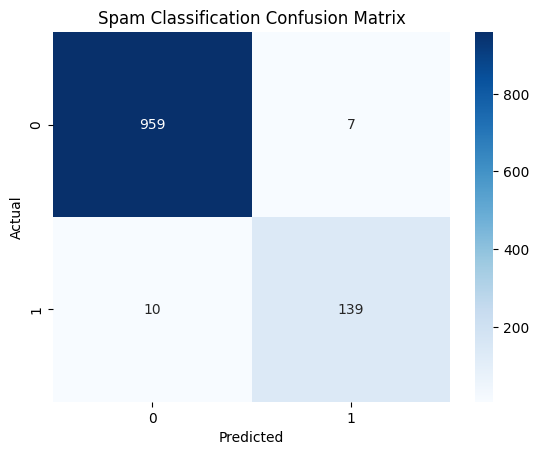

Model Trained And Saved.


In [1]:
import pandas as pd
import re
import string
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset.
df = pd.read_csv('https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv', sep='\t', names=['label', 'message'])

# Clean text.
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r"\d+", "", text)
    return text.strip()

df['message'] = df['message'].apply(clean_text)
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

X = df['message']
y = df['label_num']

# Split data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=2)),
    ('model', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

# Grid search (optional, but adds more tuning).
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'model__C': [0.1, 1, 10]
}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
grid.fit(X_train, y_train)
model = grid.best_estimator_

# Train model.
pipeline.fit(X_train, y_train)

# Evaluate.
y_pred = pipeline.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: visualize confusion matrix.
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Spam Classification Confusion Matrix')
plt.show()

# Save model.
joblib.dump(pipeline, 'Backend/App/Spam_Classifier.pkl')
print("Model Trained And Saved.")